In [1]:
#do what the keras people suggest

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('demo_style.mplstyle')

#tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [2]:
#get job info

import os

os.environ["SLURM_JOB_ID"]

'770287'

In [3]:
q003_data = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_data.npy')
#q003_max = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_max.npy')
#q003_norm = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_norm.npy')

q103_data = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_data.npy') 
#q103_max = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_max.npy')
#q103_norm = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_norm.npy')

#add in our post-quench data
#need to cut that down to size, too

pq_data = np.load('/global/cscratch1/sd/stephey/march2020_data/Q3_Q103_postquench/pq_data.npy')

In [4]:
#downsample

n = 2

q003_data = q003_data[0::n,:,:]
q103_data = q103_data[0::n,:,:]

print(q003_data.shape)
print(q103_data.shape)
print(pq_data.shape)


(1576, 625, 512)
(3318, 625, 512)
(20, 625, 512)


In [5]:
#cut to make square for later autoencoder friendly size

q003_data = q003_data[:,0:512,:]

q103_data = q103_data[:,0:512,:]

pq_data = pq_data[:,0:512,:]


In [6]:


#we shuffle in the training so it's ok
qall_data = np.concatenate((q003_data, q103_data, pq_data), axis=0)

print(qall_data.shape)


(4914, 512, 512)


In [7]:


#shuffle by default
x_train, x_test = train_test_split(qall_data, random_state=42) 
print(x_train.shape)
print(x_test.shape)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)
print(x_test.shape)

##can we memorize a single image
#x_train = x_train[0:1,:]
##train and test on the same image?
#x_test = x_train


(3685, 512, 512)
(1229, 512, 512)
(3685, 512, 512, 1)
(1229, 512, 512, 1)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


In [9]:

autoencoder = tf.keras.models.load_model('conv2d_autoencoder')

autoencoder.summary()

#this seems either buggy or we've done something wrong



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      50208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0     

In [10]:

# This function keeps the learning rate at 0.001 for the first ten epochs
# and decreases it exponentially after that.

#aim for 1e-8 at final epoch
#start with 1e-3 
#every x epochs half the learning rate

numepochs= 80

def scheduler(epoch):
    if epoch < 40:
        print("learning rate: {}".format(0.001))
        return 0.001
    else:
        print("learning rate: {}".format(0.001 * tf.math.exp(0.05 * (20 - epoch))))
        return 0.001 * tf.math.exp(0.05 * (20 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)        

history = autoencoder.fit(x_train, x_train,
                epochs=numepochs,
                batch_size=64,
                validation_data=(x_test, x_test),
                shuffle=True, 
                verbose=1,
                callbacks=[callback])

print('\nhistory dict:', history.history)

#save our encoder AND our trained model!

autoencoder.save('conv2d_autoencoder')




Train on 3685 samples, validate on 1229 samples
learning rate: 0.001
Epoch 1/80
3685/3685 [==============================] - 164s 44ms/sample - loss: 0.0368 - val_loss: 0.0357
learning rate: 0.001
Epoch 2/80
3685/3685 [==============================] - 127s 34ms/sample - loss: 0.0356 - val_loss: 0.0353
learning rate: 0.001
Epoch 3/80
3685/3685 [==============================] - 128s 35ms/sample - loss: 0.0345 - val_loss: 0.0342
learning rate: 0.001
Epoch 4/80
3685/3685 [==============================] - 128s 35ms/sample - loss: 0.0338 - val_loss: 0.0334
learning rate: 0.001
Epoch 5/80
3685/3685 [==============================] - 131s 35ms/sample - loss: 0.0331 - val_loss: 0.0327
learning rate: 0.001
Epoch 6/80
3685/3685 [==============================] - 131s 36ms/sample - loss: 0.0326 - val_loss: 0.0329
learning rate: 0.001
Epoch 7/80
3685/3685 [==============================] - 132s 36ms/sample - loss: 0.0321 - val_loss: 0.0317
learning rate: 0.001
Epoch 8/80
3685/3685 [=============

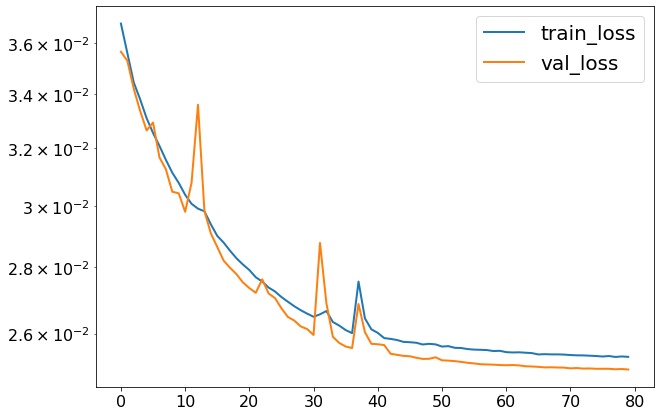

In [11]:
#plot the training loss and the validation loss

plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.yscale('log')
plt.legend()

In [12]:
encoder = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('latent').output)
encoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      50208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0     

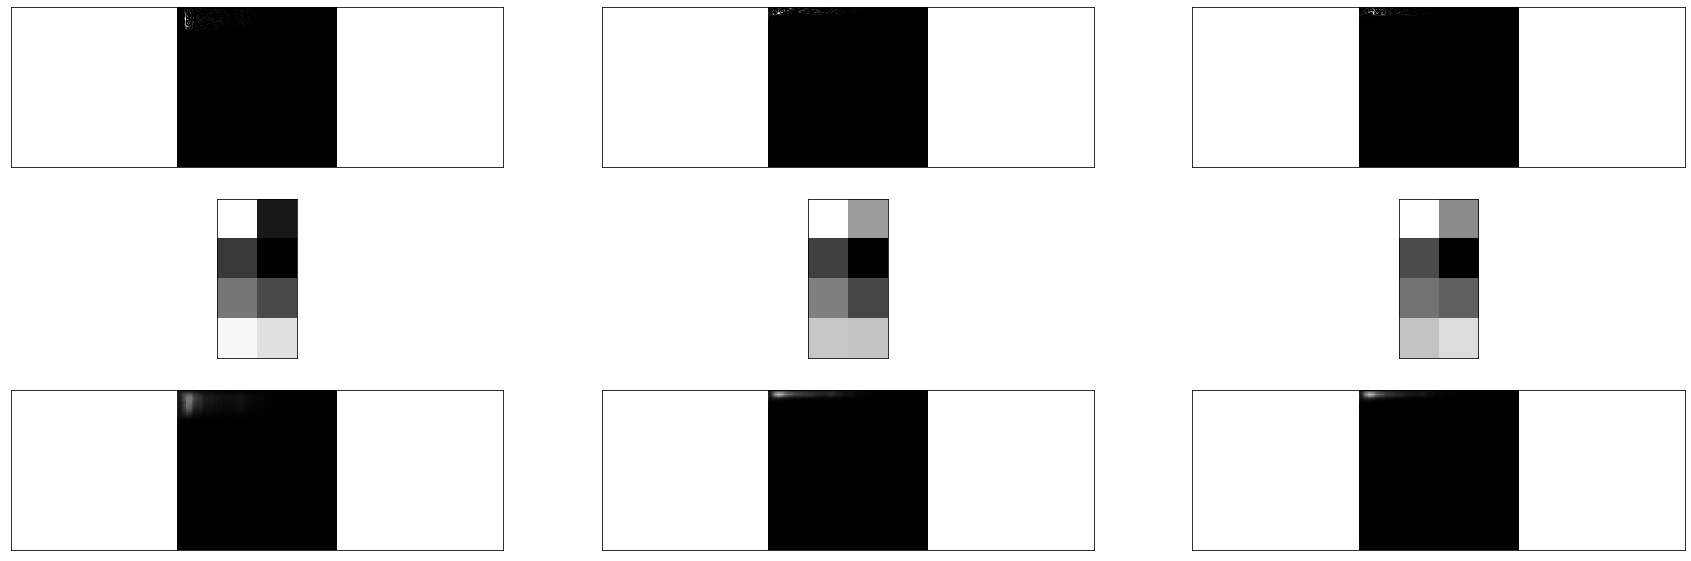

In [13]:
num_images = 3
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(30, 10))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(4,2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(512, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
plt.show()
